# After the lecture on Jan 31st.

# Implementing Convolution Module on Numpy.

* This topic will require you to implement the Convolution operation using Numpy.
* You will implement <s>two</s> one methods of doing it, an intuitive <s>and an optimised</s> way.
* <s>Additional operations like dropout, batch norms.</s>
* We will use the created Module for interesting task like Blurring, Bilateral Filtering.
* Finally, we create the Backprop for this.
* <s>Train a Conv model for the same MNIST dataset. (can be a script based training, instead of having it in jupyter notebook.)</s>


## Question 4

<br>
* Implement a naive Convolution module, with basic functionalities:
  * kernel_size,padding, stride, dilation
  
* Test out the convolution layer created, by using it to do gaussian blurring on 10 random images of Cifar10 dataset

* Bonus: Bilateral filtering can also be implemented using a 2-D convolution. Try bilateral filter for the space of (X,Y,Gray). (3D space, but not 3D conv), (no speed criteria), (Hint: You have multiple filters in each conv layer.)


In [3]:
## Define a class Convolution Layer, which is initialized with the various required params:
class convolution_layer():
    
    def __init__(self,kvargs):
        ## Refer pytorch documentation/tensorflow documentation for the parameters for the layer.
        ## Bonus for implementing Groups, no-bias functionality.
        ## Random initialization of the weights
        self.stride = kvargs['stride']
        self.pad = kvargs['zeropad']
        self.w = np.random.rand(kvargs['no_of_filters'],kvargs['channels'],kvargs['filter_height'],kvargs['filter_width'])
        self.b = np.random.rand(kvargs['no_of_filters'], 1)
        self.cache = (np.zeros(imagedata.shape), self.w, self.b, self.stride, self.pad)
        
    def forward(self,inputs):
        # Input Proprocess(According to pad etc.) Input will be of size (Batch_size, in_channels, inp_height, inp_width)
        N, C, H, W = inputs.shape
        F, C, HH, WW = self.w.shape
        S = self.stride
        P = self.pad
        x_pad = np.pad(inputs, ((0,), (0,), (P,), (P,)), 'constant') # Giving padding to each image
        
        Hh = 1 + (H + 2 * P - HH) / S # Size of the output
        Hw = 1 + (W + 2 * P - WW) / S

        output = np.zeros((N, F, Hh, Hw))
        # Reminder: Save Input for backward!
        self.cache = (inputs, self.w, self.b, S, P)
        # Simple Conv operation:
        # Loop over every location in inp_height * inp_width for the whole batch
        
        for n in range(N):  # iteration over all the images
            for f in range(F):  # iteration over all the kernels
                for k in range(Hh):
                    for l in range(Hw):
                        output[n, f, k, l] = np.sum(x_pad[n, :, k * S:k * S + HH, l * S:l * S + WW] * self.w[f, :]) + self.b[f]

        # Output will be of the size (Batch_size, out_channels, out_height, out_width)
        return output
    
    def backward(self, grad_of_output_size):
        # Naive Implementation
        # Speed is not a concern
        # Hint: gradients from each independant operation can be summed
        x, w, b, S, P = self.cache
        x_pad = np.pad(x, ((0,), (0,), (P,), (P,)), 'constant')

        N, C, H, W = x.shape
        F, C, HH, WW = w.shape
        N, F, Hh, Hw = grad_of_output_size.shape

        dw = np.zeros((F, C, HH, WW))
        for fprime in range(F):
            for cprime in range(C):
                for i in range(HH):
                    for j in range(WW):
                        sub_xpad = x_pad[:, cprime, i:i + Hh * S:S, j:j + Hw * S:S]
                        dw[fprime, cprime, i, j] = np.sum(grad_of_output_size[:, fprime, :, :] * sub_xpad)
                        
        db = np.zeros((F))
        for fprime in range(F):
            db[fprime] = np.sum(grad_of_output_size[:, fprime, :, :])

        #  return gradient of the size of the weight kernel
        return [db, dw]
    
    def set_weights(self, new_weights):
        self.w = new_weights
        ## Replace the set of weights with the given 'new_weights'
        ## use this for setting weights for blurring, bilateral filtering etc. 
    

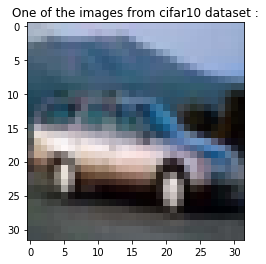

In [5]:
## get cifar images
import numpy as np
from matplotlib import pyplot as plt

def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

dataset = unpickle("cifar-10-batches-py/data_batch_1")
data = dataset['data'][0:10]
imagedata = data.reshape(10, 3, 32, 32)
imagedispdata = imagedata.transpose(0,2,3,1).astype("uint8")
imagedispdata = np.array(imagedispdata)
plt.imshow(imagedispdata[4])
plt.title('One of the images from cifar10 dataset :')
plt.show()

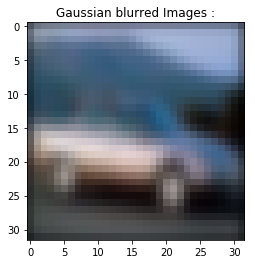

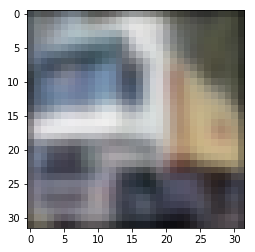

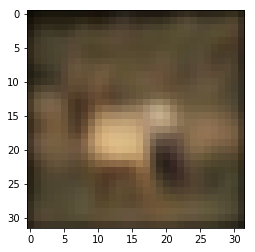

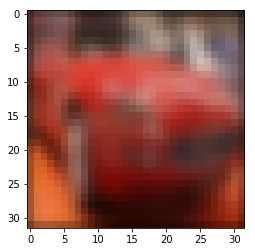

In [129]:
## Initialize a conv layer. Set weights for gaussian blurring
parameters = {}
parameters['filter_width'] = 7
parameters['filter_height'] = 7
parameters['channels'] = imagedata.shape[1]
parameters['no_of_filters'] = 3
parameters['stride'] = 1
parameters['zeropad'] = (parameters['filter_width']-1)/2

gaussian = lambda mu,sigma: np.array([np.exp(-(i-mu)**2/sigma**2/2.0) for i in range(-3*sigma,3*sigma+1)])/np.sqrt(np.pi*2)/sigma
mask_x = gaussian(0,1)
mask_y = gaussian(0,1)
mask_x.shape = (1,6*1+1)
mask_y.shape = (1,6*1+1)

final_mask = mask_y.T.dot(mask_x)

## generate output.
obj = convolution_layer(parameters)
obj.w[0] = np.array([final_mask, np.zeros([7,7]), np.zeros([7,7])])
obj.w[1] = np.array([np.zeros([7,7]),final_mask, np.zeros([7,7])])
obj.w[2] = np.array([np.zeros([7,7]), np.zeros([7,7]), final_mask])
outputdata = obj.forward(imagedata)
[db, dw] = obj.backward(output)

## use matplotlib.pyplot to show the results.
outputdata = outputdata.transpose(0,2,3,1).astype("uint8")
outputdata = np.array(outputdata)
plt.imshow(outputdata[4])
plt.title('Gaussian blurred Images :')
plt.show()
plt.imshow(outputdata[1])
plt.show()
plt.imshow(outputdata[3])
plt.show()
plt.imshow(outputdata[5])
plt.show()

In [142]:
## BONUS: Bilateral Filter.

## Question 5
<br>
Now we will use the created layer for training a simple Convolution Layer. 

* The goal is to make it learn a set of weights, by using the backpropagation function created. To test the backpropagation, instead of training a whole network, we will train only a single layer.
  * Take 100 cifar10 images. Generate a numpy array of size (20,3,5,5), with samples from uniform distribution (-1,1).Initialize a Convolution layer with 20 5$\times$5 kernels(input size 3) and set the generated weights as the layer weights. Save the output of these 100 images from this Convolution layer. 
  
  * Now, initialize a new convolution layer, and use $L_2$ loss between the output of the network and the output generated in the previous step to get the same set of weights as the ones generated in the previous step.


In [6]:
# getting 100 cifar 10 images
data = dataset['data'][0:100]
imagedata = data.reshape(100, 3, 32, 32)
## First generate the random weight vector
weight = np.random.uniform(-1,1,(20,3,5,5))
## Init a conv layer with these weights
parameters = {}
parameters['filter_width'] = 5
parameters['filter_height'] = 5
parameters['channels'] = imagedata.shape[1]
parameters['no_of_filters'] = 20
parameters['stride'] = 1
parameters['zeropad'] = (parameters['filter_width']-1)/2
obj1 = convolution_layer(parameters)
obj1.w = weight
## For all images get output. Store in numpy array.
output1 = obj1.forward(imagedata)
print " The Images output has dimension :" + str(output1.shape)

 The Images output has dimension :(100, 20, 32, 32)


In [9]:
# for part 2 we need to write a small L2 layer
class L2_loss():
    def ___init__():
        self.x = 0
        self.y = 0
        
    def forward(self, inp_1,inp_2):
        # input is of dimestion(batch,channels,h,w)
        # calculate the l2 norm of inp_1 - inp_2 .,
        self.x = inp_1 - inp_2
        output = np.sqrt(1.0*np.sum(self.x*self.x))
        self.y = output
        return output
    
    def backward(self,output_grad):
        # from the loss, and the input, get the grad at each location of the input.
        # The grad is of the shape (batch,channels,h,w)
        grad = (self.x)/self.y
        return grad

# Now Init a new conv layer and a L2 loss layer
obj2 = convolution_layer(parameters)
loss_obj = L2_loss()

Each minibatch contains : 25 samples


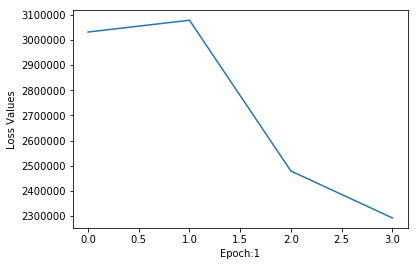

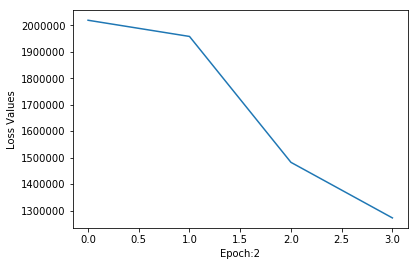

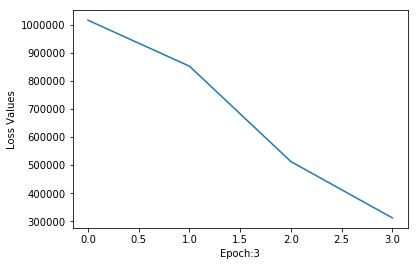

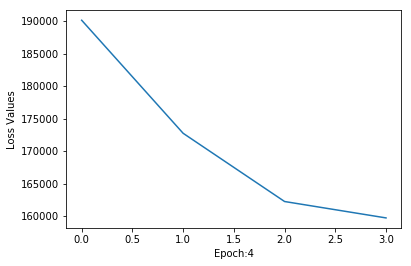

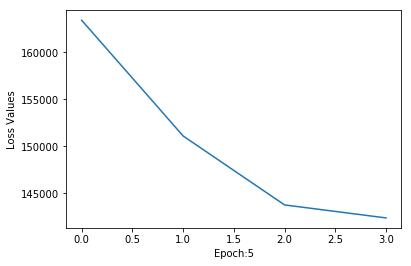

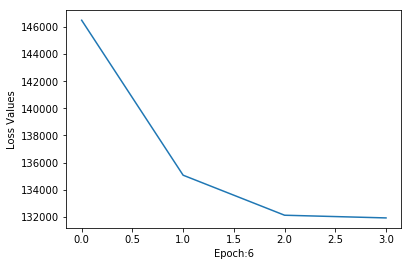

In [10]:
# Train the new conv-layer using the L2 loss to get the earlier set of generated weights.
# Use batches.
minibatch_size = 25
#np.random.seed(200)

def get_minibatch_function(training_x, training_y):
    
    def get_minibatch(training_x=training_x, training_y=training_y):
        assert training_x.shape[0] == training_y.shape[0]
        indices = np.arange(training_x.shape[0])
        #np.random.shuffle(indices)      
        for start_idx in range(0, training_x.shape[0] - minibatch_size + 1, minibatch_size):
            excerpt = indices[start_idx:start_idx + minibatch_size]
            mini_x = training_x[excerpt]
            mini_y = training_y[excerpt] 
            yield mini_x,mini_y
        
    return get_minibatch

minibatch = get_minibatch_function(imagedata, output1)
print "Each minibatch contains : " + str(minibatch_size) +" samples"

def train(epoch, lr):
    for k in range(epoch):
        lossvalues = []
        for iter,(input_x, input_y) in enumerate(minibatch()):

                ## Write code here for each iteration of training.
                y_predicted = obj2.forward(input_x)
                loss = loss_obj.forward(y_predicted,input_y)
                lossvalues.append(loss)
                grad_from_loss = loss_obj.backward(1)
                [db,dw] = obj2.backward(grad_from_loss)
                db= db.reshape(len(db),1)
                #dw = np.dot(dw , grad_from_loss)
                lr = lr * ((0.000001 * iter + 1) ** -0.75)
                obj2.w += -lr * dw
                obj2.b += -lr * db
                

        plt.plot(lossvalues)
        plt.ylabel('Loss Values')
        plt.xlabel('Epoch:' + str(k+1))
        plt.show()
train(6, 0.00001)

In [11]:
# L2 distance between the weights
diff = weight- obj2.w
print " The L2 distance between the weights is : "+ str(np.sqrt(1.0*np.sum(diff*diff)))
# Print L2 dist between output from new convolution layer and the outputs generated initially.
output2 = obj2.forward(imagedata)
diff = output1 - output2
print "The L2 distance between outputs is : "+ str(np.sqrt(1.0*np.sum(diff*diff)))

 The L2 distance between the weights is : 23.969891574
The L2 distance between outputs is : 260743.565388
